# Dataset Validation for XGBoost Training

This notebook validates the final dataset created by the DatasetCreator to ensure it's suitable for XGBoost training.

## Key Validation Areas:
1. **Data Loading & Basic Info**
2. **Missing Value Analysis**
3. **Outlier Detection**
4. **Data Type Validation**
5. **Feature Distribution Analysis**
6. **XGBoost Readiness Check**

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Data Loading & Basic Information

In [3]:
# Load the dataset
dataset_path = 'dataset/credit_risk_dataset.csv'
df = pd.read_csv(dataset_path)

print(f"📊 Dataset loaded successfully!")
print(f"📈 Shape: {df.shape}")
print(f"📋 Columns: {len(df.columns)}")

# Check if date column exists
if '보험청약일자' in df.columns:
    print(f"\n📅 Date range: {df['보험청약일자'].min()} to {df['보험청약일자'].max()}")

# Display first few rows
print("\n🔍 First 5 rows:")
display(df.head())

📊 Dataset loaded successfully!
📈 Shape: (37276, 57)
📋 Columns: 57

📅 Date range: 2017-07-17 to 2024-06-28

🔍 First 5 rows:


,사업자등록번호,대상자명,대상자등록이력일시,업종코드1,대상자기본주소,청약번호,보험청약일자,청약상태코드,수출자대상자번호,특별출연협약코드,...,industry_매출_및_현금흐름_변동성_수출자_점수,industry_수익성_악화_위험_수출자_점수,industry_원자재_및_공급망_리스크_수출자_점수,industry_자본_집약도_및_고정비_수출자_점수,industry_국가_전략적_소외_위험_한국특성_점수,industry_글로벌_가치사슬_내_저부가가치_위험_한국특성_점수,industry_무역수지_적자_및_시장_종속성_한국특성_점수,industry_산업의_지정학적_취약성_한국특성_점수,industry_수출_시장_집중도_및_불안정성_한국특성_점수,industry_핵심_부품소재_해외_의존도_한국특성_점수
0,1010183242,KIPEC,20180531,25933.0,경기도 여주시 강천면 강천리길,152014065417,2018-06-05,00700,3100023331,NaN,...,60.0,90.0,65.0,60.0,80.0,88.0,85.0,15.0,40.0,55.0
1,1010183242,KIPEC,20190529,25933.0,경기도 여주시 강천면 강천리길,152014065417,2019-06-03,00700,3100023331,NaN,...,60.0,90.0,65.0,60.0,80.0,88.0,85.0,15.0,40.0,55.0
2,1010183242,KIPEC,20200529,25933.0,경기도 여주시 강천면 강천리길,152014065417,2020-06-01,00945,3100023331,NaN,...,60.0,90.0,65.0,60.0,80.0,88.0,85.0,15.0,40.0,55.0
3,1010183242,KIPEC,20200529,25933.0,경기도 여주시 강천면 강천리길,150521050303,2021-05-12,00700,3100023331,NaN,...,60.0,90.0,65.0,60.0,80.0,88.0,85.0,15.0,40.0,55.0
4,1010183242,KIPEC,20220525,25933.0,경기도 여주시 강천면 강천리길,150521050303,2022-05-25,00700,3100023331,NaN,...,60.0,90.0,65.0,60.0,80.0,88.0,85.0,15.0,40.0,55.0


In [4]:
# Basic dataset information
print("📊 DATASET OVERVIEW")
print("=" * 50)

# Data types
print("\n📋 Data Types:")
print(df.dtypes.value_counts())

# Memory usage
memory_usage = df.memory_usage(deep=True).sum() / 1024**2
print(f"\n💾 Memory usage: {memory_usage:.2f} MB")

# Y variables summary
y_cols = [col for col in df.columns if col.startswith('risk_year')]
print(f"\n🎯 Y Variables: {len(y_cols)}")
for col in y_cols:
    print(f"   {col}: {df[col].value_counts().sort_index().to_dict()}")

📊 DATASET OVERVIEW

📋 Data Types:
float64    48
int64       5
object      4
Name: count, dtype: int64

💾 Memory usage: 27.23 MB

🎯 Y Variables: 4
   risk_year1: {0: 33017, 1: 3060, 2: 735, 3: 464}
   risk_year2: {0.0: 26283, 1.0: 5336, 2.0: 1244, 3.0: 833}
   risk_year3: {0.0: 20303, 1.0: 7025, 2.0: 1651, 3.0: 1128}
   risk_year4: {0.0: 14858, 1.0: 8353, 2.0: 1962, 3.0: 1367}


## 2. Missing Value Analysis

In [5]:
# Comprehensive missing value analysis
print("🔍 MISSING VALUE ANALYSIS")
print("=" * 50)

# Calculate missing values
missing_data = df.isnull().sum()
missing_pct = (missing_data / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Percentage', ascending=False)

# Display missing values summary
print(f"\n📊 Total missing values: {missing_data.sum():,}")
print(f"📊 Overall missing percentage: {(missing_data.sum() / (len(df) * len(df.columns)) * 100):.2f}%")

# Show columns with missing values
missing_cols = missing_df[missing_df['Missing_Count'] > 0]
print(f"\n⚠️ Columns with missing values: {len(missing_cols)}")
display(missing_cols.head(10))

🔍 MISSING VALUE ANALYSIS

📊 Total missing values: 124,848
📊 Overall missing percentage: 5.88%

⚠️ Columns with missing values: 46


,Missing_Count,Missing_Percentage
특별출연협약코드,34612,92.85
grade_KED신용등급코드_0,15689,42.09
risk_year4,10736,28.80
risk_year3,7169,19.23
risk_year2,3580,9.60
financial_매출액_t2,2074,5.56
financial_부채_t2,2029,5.44
financial_판매비와관리비_t2,1972,5.29
financial_자기자본_t2,1969,5.28
financial_당기순이익_t2,1968,5.28


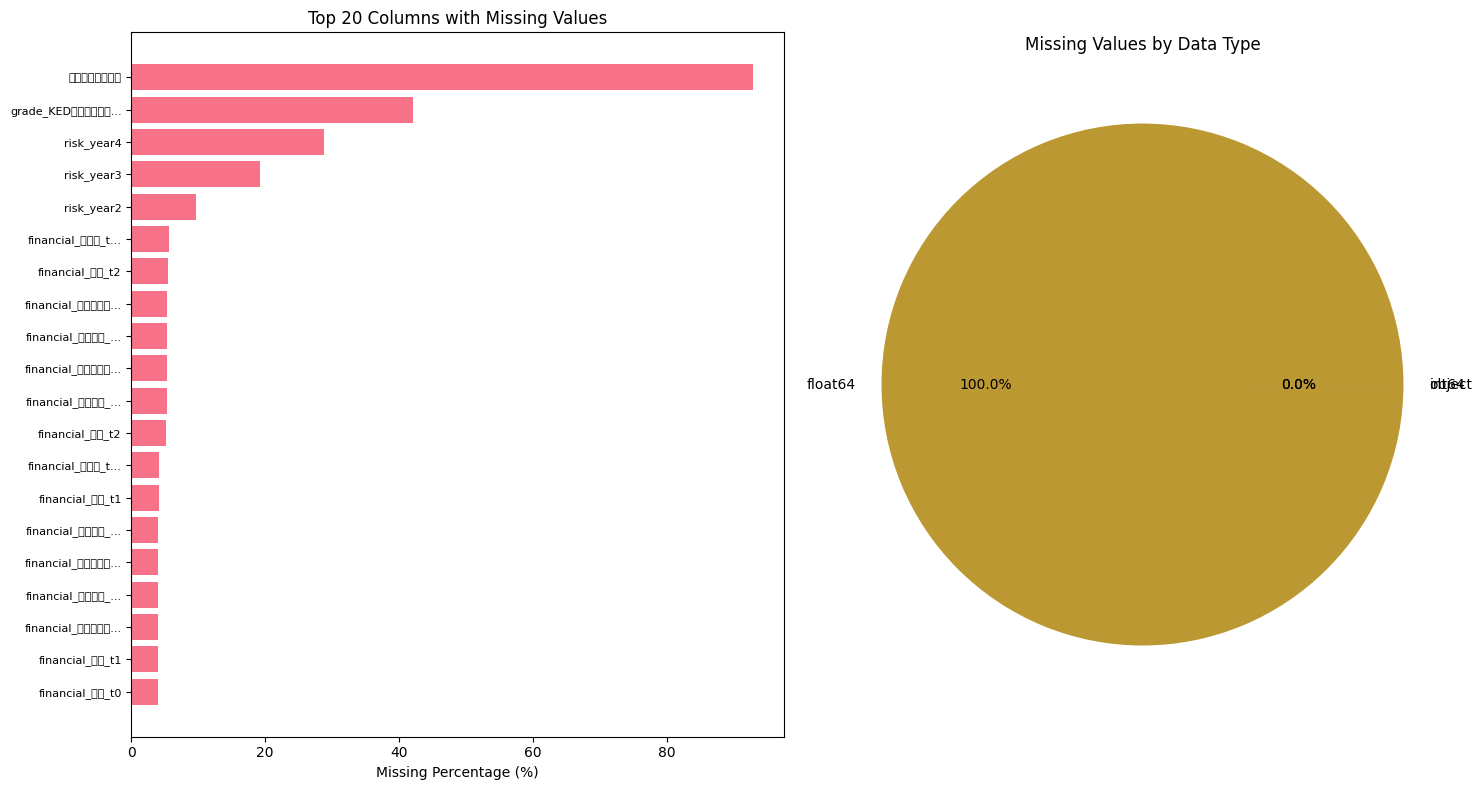

In [6]:
# Visualize missing values
plt.figure(figsize=(15, 8))

# Plot 1: Missing values bar chart
plt.subplot(1, 2, 1)
missing_cols_plot = missing_cols.head(20)  # Top 20 columns with most missing values
if len(missing_cols_plot) > 0:
    plt.barh(range(len(missing_cols_plot)), missing_cols_plot['Missing_Percentage'])
    plt.yticks(range(len(missing_cols_plot)), [col[:15] + '...' if len(col) > 15 else col for col in missing_cols_plot.index], fontsize=8)
    plt.xlabel('Missing Percentage (%)')
    plt.title('Top 20 Columns with Missing Values')
    plt.gca().invert_yaxis()
else:
    plt.text(0.5, 0.5, 'No Missing Values Found', ha='center', va='center', fontsize=14)
    plt.title('Missing Values Analysis')

# Plot 2: Missing values by data type
plt.subplot(1, 2, 2)
missing_by_type = df.groupby(df.dtypes, axis=1).apply(lambda x: x.isnull().sum().sum())
if missing_by_type.sum() > 0:
    plt.pie(missing_by_type.values, labels=missing_by_type.index, autopct='%1.1f%%')
    plt.title('Missing Values by Data Type')
else:
    plt.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=14)
    plt.title('Missing Values by Data Type')

plt.tight_layout()
plt.show()

## 3. Outlier Detection

In [7]:
# Outlier detection using IQR method
print("🔍 OUTLIER DETECTION")
print("=" * 50)

def detect_outliers_iqr(df, threshold=1.5):
    """Detect outliers using Interquartile Range method"""
    
    # Select numeric columns only
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    outlier_summary = {}
    
    for col in numeric_cols:
        if col.startswith('risk_year'):  # Skip Y variables
            continue
            
        data = df[col].dropna()
        if len(data) == 0:
            continue
            
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = data[(data < lower_bound) | (data > upper_bound)]
            
        outlier_summary[col] = {
            'outlier_count': len(outliers),
            'outlier_percentage': len(outliers) / len(data) * 100,
            'min_value': data.min(),
            'max_value': data.max(),
            'mean_value': data.mean(),
            'std_value': data.std()
        }
    
    return outlier_summary

# Detect outliers
print("\n📊 Detecting outliers using IQR method...")
outlier_results = detect_outliers_iqr(df)

# Create summary dataframe
outlier_df = pd.DataFrame(outlier_results).T
outlier_df = outlier_df.sort_values('outlier_percentage', ascending=False)

print(f"\n📈 Outlier Analysis Summary:")
print(f"   Total features analyzed: {len(outlier_df)}")
print(f"   Features with outliers: {len(outlier_df[outlier_df['outlier_count'] > 0])}")
print(f"   Average outlier percentage: {outlier_df['outlier_percentage'].mean():.2f}%")

# Show top features with most outliers
print("\n⚠️ Top 10 features with most outliers:")
display(outlier_df.head(10)[['outlier_count', 'outlier_percentage', 'min_value', 'max_value']])

🔍 OUTLIER DETECTION

📊 Detecting outliers using IQR method...

📈 Outlier Analysis Summary:
   Total features analyzed: 49
   Features with outliers: 41
   Average outlier percentage: 6.58%

⚠️ Top 10 features with most outliers:


,outlier_count,outlier_percentage,min_value,max_value
financial_당기순이익_t0,7269.0,20.285204,-2.399454e+08,8.619614e+07
financial_당기순이익_t1,6893.0,19.265491,-1.157725e+08,8.619614e+07
financial_당기순이익_t2,6534.0,18.505721,-1.157725e+08,8.619614e+07
financial_영업이익_t0,5861.0,16.355975,-5.081455e+07,7.992533e+07
financial_영업이익_t1,5655.0,15.805361,-5.108464e+07,6.917377e+07
financial_영업이익_t2,5421.0,15.353896,-6.917421e+07,6.917377e+07
trade_trade_balance_change_mom_0,4493.0,12.053332,-1.565400e+02,9.667870e+03
financial_자기자본_t0,4170.0,11.638942,-2.291594e+08,3.378696e+08
financial_자기자본_t2,4070.0,11.527459,-3.752881e+07,2.776735e+08
financial_자기자본_t1,4089.0,11.429769,-4.040465e+07,3.033638e+08


## 4. XGBoost Readiness Check

In [8]:
# Final XGBoost readiness assessment
print("🎯 XGBOOST READINESS ASSESSMENT")
print("=" * 50)

# Initialize assessment
assessment = {
    'data_loading': True,
    'missing_values': True,
    'outliers': True,
    'data_types': True,
    'recommendations': []
}

# Check 1: Data loading
print("\n✅ 1. Data Loading:")
print(f"   Dataset shape: {df.shape}")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
if df.shape[0] > 0 and df.shape[1] > 0:
    print("   ✅ Data loaded successfully")
else:
    assessment['data_loading'] = False
    assessment['recommendations'].append("Dataset is empty")

# Check 2: Missing values
print("\n✅ 2. Missing Values:")
total_missing = df.isnull().sum().sum()
missing_pct = total_missing / (len(df) * len(df.columns)) * 100
print(f"   Total missing: {total_missing:,} ({missing_pct:.2f}%)")

if missing_pct > 50:
    assessment['missing_values'] = False
    assessment['recommendations'].append("Too many missing values (>50%)")
elif missing_pct > 20:
    assessment['recommendations'].append("High missing values (20-50%) - consider imputation")
else:
    print("   ✅ Missing values are acceptable")

# Check 3: Outliers
print("\n✅ 3. Outliers:")
high_outlier_features = outlier_df[outlier_df['outlier_percentage'] > 30]
if len(high_outlier_features) > 0:
    print(f"   ⚠️ {len(high_outlier_features)} features have >30% outliers")
    assessment['recommendations'].append(f"{len(high_outlier_features)} features have excessive outliers")
else:
    print("   ✅ Outlier levels are acceptable")

# Check 4: Data types
print("\n✅ 4. Data Types:")
object_cols = df.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    print(f"   ⚠️ {len(object_cols)} object columns need encoding")
    assessment['data_types'] = False
    assessment['recommendations'].append(f"Encode {len(object_cols)} categorical variables")
else:
    print("   ✅ All columns are numeric")

# Overall assessment
print("\n🎯 OVERALL ASSESSMENT:")
all_checks = all([v for k, v in assessment.items() if k != 'recommendations'])
if all_checks:
    print("   ✅ Dataset is READY for XGBoost training!")
else:
    print("   ⚠️ Dataset needs preprocessing before XGBoost training")

# Recommendations
if assessment['recommendations']:
    print("\n💡 RECOMMENDATIONS:")
    for i, rec in enumerate(assessment['recommendations'], 1):
        print(f"   {i}. {rec}")
else:
    print("\n💡 No specific recommendations - dataset looks good!")

# Final summary
print("\n📊 FINAL SUMMARY:")
print(f"   Dataset shape: {df.shape}")
print(f"   Missing values: {missing_pct:.2f}%")
print(f"   Object columns: {len(object_cols)}")
print(f"   Ready for XGBoost: {'Yes' if all_checks else 'No'}")

print("\n✅ Dataset validation completed!")
print("\n🚀 You can now proceed with XGBoost training after addressing any recommendations above.")

🎯 XGBOOST READINESS ASSESSMENT

✅ 1. Data Loading:
   Dataset shape: (37276, 57)
   Memory usage: 27.23 MB
   ✅ Data loaded successfully

✅ 2. Missing Values:
   Total missing: 124,848 (5.88%)
   ✅ Missing values are acceptable

✅ 3. Outliers:
   ✅ Outlier levels are acceptable

✅ 4. Data Types:
   ⚠️ 4 object columns need encoding

🎯 OVERALL ASSESSMENT:
   ⚠️ Dataset needs preprocessing before XGBoost training

💡 RECOMMENDATIONS:
   1. Encode 4 categorical variables

📊 FINAL SUMMARY:
   Dataset shape: (37276, 57)
   Missing values: 5.88%
   Object columns: 4
   Ready for XGBoost: No

✅ Dataset validation completed!

🚀 You can now proceed with XGBoost training after addressing any recommendations above.
